In [2]:
import numpy as np
import gym
import torch
import sys
import time
if '../' not in sys.path:
    sys.path.insert(0,'../')
    
import pickle
from solvers.visuals import *
from solvers.utils import greedy_policy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


## Cartpole using DQN

In this notebook cartpole is solved using DQN via a feed forward neural network.

In [21]:
env = gym.make('CartPole-v0').unwrapped
env._obs_type = 'vector' # required for DQN method in solvers

In [22]:
# load trained agent model
from solvers.models import NeuralNet
from solvers import dqn

model = NeuralNet(env)
PATH = '../ccr/data/cpagent.pth'
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval()
agent = dqn.DQN(env,'epsgreedy',NeuralNet,num_episodes=7000, N=2500, C = 200)  


In [27]:
# Transfer the policy from GPU to CPU
def dqnpolicy(model, agent,state):
    """
    Helper function that returns an action given a state and a learned model.
    Transfer model from GPU to CPU 
    """
    T = [state,0,state,0]
    X, _,_ = agent.phi(T)   
    X = X.unsqueeze(0)
    X = X.to(device)
    _,action = torch.max(model(X).data,1)

    return action.cpu().numpy()

def run_experiments(env,policy):
    """
    Perform 100 random runs of the environment with learned agent and print average score
    """
    totalrewards = 0
    for trial in range(100):
        state = env.reset()
        episode_reward = 0
        is_done = False
        while not is_done:
            action = policy(state)
            state,r,is_done,info = env.step(action[0]) # take a random action
            totalrewards += r
            episode_reward += r

            if is_done:
                break
        sys.stdout.write("\r" + "Episode: " + str(trial)+ "\t Episode Rewards: " +  str(episode_reward))
        sys.stdout.flush()
        time.sleep(0.01)

    print('\nAverage reward: {}'.format(totalrewards/100))

In [28]:
# play the environment for 100 consecutive episodes and print avergae score
run_experiments(env,lambda state: dqnpolicy(model, agent,state))

Episode: 99	 Episode Rewards: 129.0
Average reward: 120.95


## Cartpole DDQN

In [29]:
PATH = '../ccr/data/cpddqnagent.pth'
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval()

NeuralNet(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)

In [30]:
# play the environment for 100 consecutive episodes and print avergae score
run_experiments(env,lambda state: dqnpolicy(model, agent,state))

Episode: 99	 Episode Rewards: 129.0
Average reward: 138.18


## SpaceInvaders Atari DQN

In [31]:
RES = 64 #set down selected resolution of Image output from environments

In [32]:
from torchvision import transforms
from PIL import Image

def phi_image(T, res = RES):
    grayim = transforms.Compose(
        [transforms.Resize((res,res)),
         transforms.Grayscale(num_output_channels=1), transforms.ToTensor(),
         ])
    X = torch.zeros(len(T[0]),res,res)
    Xn = X
    for frame in range(len(T[0])):
        img = Image.fromarray((T[0][frame] * 255).astype(np.uint8))
        X[frame,:,:]  = grayim(img)
        img = Image.fromarray((T[2][frame] * 255).astype(np.uint8))
        Xn[frame,:,:]  = grayim(img) 
    
    X.requires_grad = True
    Xn.requires_grad = True
    R = torch.tensor(T[3]).float()
    
    return X, R, Xn

In [33]:
# Use a wrapped version of atari game to account for frameskipping and running on server
from gym.envs.atari.atari_env import AtariEnv

class env(AtariEnv):
    def __init__(self):
        super(env,self).__init__(game='space_invaders',obs_type='image',frameskip=4)
        if isinstance(self.frameskip, int):
            self.num_steps = self.frameskip
        else:
            raise NotImplementedError()
    def step(self, a):
        reward = 0.0
        ob = []
        action = self._action_set[a]
        for s in range(self.num_steps):
            reward += self.ale.act(action)
            ob.append(self._get_obs())
        return ob, reward, self.ale.game_over(), {"ale.lives": self.ale.lives()}
    def reset(self):
        ob = []
        for s in range(self.num_steps):
            self.ale.reset_game()
            ob.append(self._get_obs())        
        return ob
env = env()

In [35]:
from solvers.models import Convnet

model = Convnet(env,num_channels=4, res=RES)
PATH = '../ccr/data/dqn_space_invaders_agent.pth'
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval()

Convnet(
  (layer1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (fc1): Linear(in_features=1800, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)

In [36]:
# Transfer the policy from GPU to CPU
def dqnpolicy(model, agent,state):
    T = [state,0,state,0]
    X, _,_ = phi_image(T)   
    X = X.unsqueeze(0)
    X = X.to(device)
    _,action = torch.max(model(X).data,1)

    return action.cpu().numpy()

In [37]:
# play the environment for 100 consecutive episodes and print avergae score
run_experiments(env,lambda state: dqnpolicy(model, agent,state))

Episode: 99	 Episode Rewards: 265.0
Average reward: 265.0


In [38]:
PATH = '../ccr/data/ddqn_space_invaders_agent.pth'
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval()

Convnet(
  (layer1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (fc1): Linear(in_features=1800, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)

In [39]:
run_experiments(env,lambda state: dqnpolicy(model, agent,state))

Episode: 99	 Episode Rewards: 210.0
Average reward: 210.0


## Comparing DQN vs D-DQN

In [3]:
import pickle

sidqn = pickle.load( open( "../ccr/data/dqn_space_invaders_agenttrace.pkl", "rb" ) )
siddqn = pickle.load( open( "../ccr/data/ddqn_space_invaders_agenttrace.pkl", "rb" ) )
cpddqn = pickle.load( open( "../ccr/data/cpddqnagenttrace.pkl", "rb" ) )
cpdqn = pickle.load( open( "../ccr/data/cpagenttrace.pkl", "rb" ) )


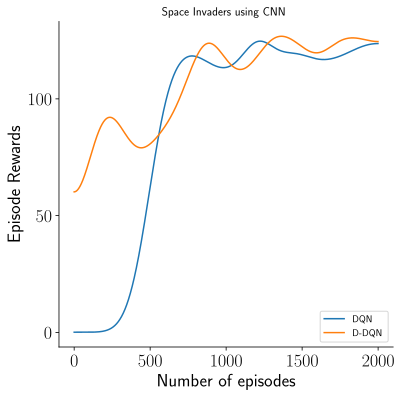

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d
import numpy as np
from matplotlib import rc
rc('text', usetex=True)
from solvers.visuals import _clean_figure
%config InlineBackend.figure_format = 'svg'

def compare_learning_trace(trace1,trace2,ax,N):
    ys1 = gaussian_filter1d(trace1['rewards'], sigma=100)
    ys2 = gaussian_filter1d(trace2['rewards'], sigma=100)
    ax.plot(np.arange(N),ys1)
    ax.plot(np.arange(N),ys2)
    ax.set_ylabel('Episode Rewards')
    ax.set_xlabel('Number of episodes')
    sns.despine()
    _clean_figure(ax)
    
    return ax

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax = compare_learning_trace(sidqn,siddqn,ax,2000)
ax.legend(['DQN','D-DQN'],loc='lower right')
plt.savefig('SpaceInvaders.pdf',dpi=500,bbox_inches='tight')
ax.set_title('Space Invaders using CNN')
plt.show()

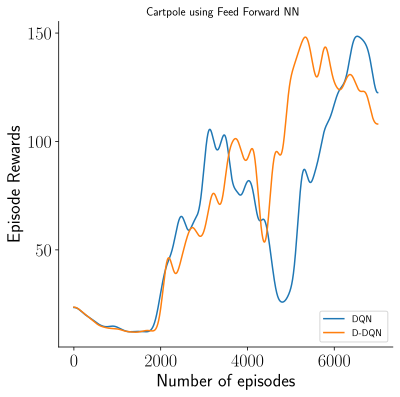

In [12]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax = compare_learning_trace(cpdqn,cpddqn,ax,7000)
ax.legend(['DQN','D-DQN'],loc='lower right')
plt.savefig('CartPole.pdf',dpi=500,bbox_inches='tight')
ax.set_title('Cartpole using Feed Forward NN')
plt.show()